In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
from datetime import datetime
from functools import reduce

# Set data folder
data_folder = '/content/drive/MyDrive/Capstone Data/Final Data'
if not os.path.exists(data_folder):
    raise FileNotFoundError(f"Data folder not found: {data_folder}. Contents: {os.listdir('/content/drive/MyDrive')}")
print(f"Files in {data_folder}: {os.listdir(data_folder)}")

# Define rename dictionary for predictors
rename_dict = {
    'Annual Labor Force Survey': 'Labor_Force_Survey',
    'clean_import_of_goods_and_services_as_a_percentage_of_GDP (1)': 'Imports_to_GDP',
    'clean_inflation_rate (2)': 'Inflation_Rate',
    'clean_labor_force_participation_rate_modeled': 'Labor_Force_Participation',
    'Cleaned_GDP_Per_Capita_Data_2010_2023 - Cleaned_GDP_Per_Capita_Data_2010_2023': 'GDP_Per_Capita',
    'export_of_goods_and_services___GDP (1)': 'Exports_to_GDP',
    'Filtered_FDI_2010_2023': 'FDI',
    'filtered_gdp_usd (1)': 'GDP_USD',
    'Filtered_Real_Interest_Rates_Final': 'Real_Interest_Rates',
    'Filtered_Unemployment_Rate': 'Unemployment_Rate',
    'population_growth_cleaned': 'Population_Growth',
    'tax_to_gdp_2009_2023': 'Tax_to_GDP',
    'filtered_corruption_score(0-100)': 'Corruption',
    'Average Wage Data  - Average Wage Data ': 'Wage'
}

# List of predictor files
files = [
    'Annual Labor Force Survey.csv',
    'clean_import_of_goods_and_services_as_a_percentage_of_GDP (1).csv',
    'clean_inflation_rate (2).csv',
    'clean_labor_force_participation_rate_modeled.csv',
    'Cleaned_GDP_Per_Capita_Data_2010_2023 - Cleaned_GDP_Per_Capita_Data_2010_2023.csv',
    'export_of_goods_and_services___GDP (1).csv',
    'Filtered_FDI_2010_2023.csv',
    'filtered_gdp_usd (1).csv',
    'Filtered_Real_Interest_Rates_Final.csv',
    'Filtered_Unemployment_Rate.csv',
    'population_growth_cleaned.csv',
    'tax_to_gdp_2009_2023.csv',
    'filtered_corruption_score(0-100).csv',
    'Average Wage Data  - Average Wage Data .csv'
]

# Target variable file
target_file = 'Public_Sector_Debt.csv'

Files in /content/drive/MyDrive/Capstone Data/Final Data: ['tax_to_gdp_2009_2023.csv', 'population_growth_cleaned.csv', 'Filtered_Unemployment_Rate.csv', 'Filtered_Real_Interest_Rates_Final.csv', 'Filtered_FDI_2010_2023.csv', 'export_of_goods_and_services___GDP (1).csv', 'Cleaned_GDP_Per_Capita_Data_2010_2023 - Cleaned_GDP_Per_Capita_Data_2010_2023.csv', 'clean_labor_force_participation_rate_modeled.csv', 'clean_inflation_rate (2).csv', 'clean_import_of_goods_and_services_as_a_percentage_of_GDP (1).csv', 'Annual Labor Force Survey.csv', 'Tax_Revenue_2010_2023_updated - Tax_Revenue_2010_2023_updated.csv', 'filtered_urban_population(% of total polpulation) - filtered_urban_population(% of total polpulation).csv', 'Average Wage Data  - Average Wage Data .csv', 'filtered_gdp_usd (1).csv', 'WUI_Annual_Averages_2009_2023_Pivot (1).gsheet', 'CPI.csv', 'filtered_corruption_score(0-100).csv', '.ipynb_checkpoints', 'Public_Sector_Debt.csv', 'regression_results_20250428_191016.csv', 'regression_r

In [3]:
# Function to load and preprocess data
def load_and_preprocess(file_path):
    try:
        df = pd.read_csv(os.path.join(data_folder, file_path))
        df['CCode'] = df['CCode'].astype(str)
        year_cols = [col for col in df.columns if col not in ['CCode', 'Country', 'Country Name'] and col.isdigit()]
        df_melt = pd.melt(df, id_vars=['CCode'], value_vars=year_cols,
                          var_name='Year', value_name=file_path.split('.')[0])
        df_melt['Year'] = df_melt['Year'].astype(int)
        value_col = file_path.split('.')[0]
        if df_melt[value_col].dtype not in ['float64', 'int64']:
            df_melt[value_col] = pd.to_numeric(df_melt[value_col].astype(str).str.replace(',', ''), errors='coerce')
        if value_col in rename_dict:
            df_melt = df_melt.rename(columns={value_col: rename_dict[value_col]})
        return df_melt
    except Exception as e:
        print(f"Error processing {file_path}: {type(e).__name__} - {str(e)}")
        return None

# Load target variable
target_df = load_and_preprocess(target_file)
if target_df is None:
    raise ValueError("Failed to load target file")
target_df = target_df.rename(columns={target_file.split('.')[0]: 'Public_Sector_Debt'})

# Load all predictor datasets
predictor_dfs = []
for file in files:
    df = load_and_preprocess(file)
    if df is not None:
        predictor_dfs.append(df)
    else:
        print(f"Skipping {file} due to loading error")

# Merge all datasets (left join to retain all target data)
merged_df = target_df
for df in predictor_dfs:
    merged_df = pd.merge(merged_df, df, on=['CCode', 'Year'], how='left')

# Check missing values
print("Missing values before imputation:")
print(merged_df.isna().sum())
initial_rows = merged_df.shape[0]

Missing values before imputation:
CCode                        0
Year                         0
Public_Sector_Debt           0
Labor_Force_Survey           0
Imports_to_GDP               0
Inflation_Rate               0
Labor_Force_Participation    0
GDP_Per_Capita               0
Exports_to_GDP               0
FDI                          0
GDP_USD                      0
Real_Interest_Rates          0
Unemployment_Rate            0
Population_Growth            0
Tax_to_GDP                   0
Corruption                   0
Wage                         0
dtype: int64


In [ ]:
# Step 1: Select predictor variables
predictors = list(rename_dict.values())

# Verify predictors exist in merged_df
missing_preds = [p for p in predictors if p not in merged_df.columns]
if missing_preds:
    print(f"Warning: Missing predictors in merged_df: {missing_preds}")
    predictors = [p for p in predictors if p in merged_df.columns]

# Step 2: Handle missing values (impute with country-specific medians)
for col in predictors:
    merged_df[col] = merged_df.groupby('CCode')[col].transform(lambda x: x.fillna(x.median()))
# Impute remaining NaNs (e.g., countries with no data) with global median
for col in predictors:
    merged_df[col] = merged_df[col].fillna(merged_df[col].median())

print("Missing values after imputation:")
print(merged_df.isna().sum())
print(f"Shape of merged dataset: {merged_df.shape}")
print(f"Rows retained: {merged_df.shape[0]} ({(merged_df.shape[0] / initial_rows) * 100:.2f}%)")

# Step 3: Standardize predictors
scaler = StandardScaler()
X = merged_df[predictors]
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors, index=X.index)

# Step 4: Apply PCA
pca = PCA()
principal_components = pca.fit_transform(X_scaled_df)

# Create DataFrame for principal components
pc_columns = [f'PC{i+1}' for i in range(len(predictors))]
pc_df = pd.DataFrame(principal_components, columns=pc_columns, index=X.index)

# Step 5: Analyze PCA Results
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Component loadings
loadings = pd.DataFrame(pca.components_.T, columns=pc_columns, index=predictors)

# Step 6: Visualization
# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, label='Individual Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'r-o', label='Cumulative Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.grid(True)
variance_plot_path = os.path.join(data_folder, f'pca_variance_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png')
plt.savefig(variance_plot_path)
plt.close()
print(f"Variance plot saved to {variance_plot_path}")

# Plot loadings for PC1 vs. PC2
plt.figure(figsize=(12, 8))
for predictor in predictors:
    plt.scatter(loadings.loc[predictor, 'PC1'], loadings.loc[predictor, 'PC2'], label=predictor)
    plt.text(loadings.loc[predictor, 'PC1'], loadings.loc[predictor, 'PC2'], predictor)
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.axvline(0, color='black', linestyle='--', alpha=0.3)
plt.xlabel('PC1 Loading')
plt.ylabel('PC2 Loading')
plt.title('PCA Loadings for PC1 vs. PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
loadings_plot_path = os.path.join(data_folder, f'pca_loadings_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png')
plt.savefig(loadings_plot_path, bbox_inches='tight')
plt.close()
print(f"Loadings plot saved to {loadings_plot_path}")

# Step 7: Save Results
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# Save principal components
pc_df.to_csv(os.path.join(data_folder, f'pca_components_{timestamp}.csv'))
print(f"Principal components saved to {data_folder}/pca_components_{timestamp}.csv")

# Save explained variance
variance_df = pd.DataFrame({
    'Component': pc_columns,
    'Explained_Variance_Ratio': explained_variance_ratio,
    'Cumulative_Variance': cumulative_variance
})
variance_df.to_csv(os.path.join(data_folder, f'pca_variance_{timestamp}.csv'), index=False)
print(f"Variance data saved to {data_folder}/pca_variance_{timestamp}.csv")

# Save loadings
loadings.to_csv(os.path.join(data_folder, f'pca_loadings_{timestamp}.csv'))
print(f"Loadings saved to {data_folder}/pca_loadings_{timestamp}.csv")

# Print summary
print("\nPCA Summary:")
print(variance_df)
print("\nComponent Loadings:")
print(loadings)

Missing values after imputation:
CCode                        0
Year                         0
Public_Sector_Debt           0
Labor_Force_Survey           0
Imports_to_GDP               0
Inflation_Rate               0
Labor_Force_Participation    0
GDP_Per_Capita               0
Exports_to_GDP               0
FDI                          0
GDP_USD                      0
Real_Interest_Rates          0
Unemployment_Rate            0
Population_Growth            0
Tax_to_GDP                   0
Corruption                   0
Wage                         0
dtype: int64
Shape of merged dataset: (518, 17)
Rows retained: 518 (100.00%)
Variance plot saved to /content/drive/MyDrive/Capstone Data/Final Data/pca_variance_20250421_212036.png
Loadings plot saved to /content/drive/MyDrive/Capstone Data/Final Data/pca_loadings_20250421_212038.png
Principal components saved to /content/drive/MyDrive/Capstone Data/Final Data/pca_components_20250421_212039.csv
Variance data saved to /content/drive/MyDr

In [ ]:
merged_df = merged_df.join(pc_df)

VIF values (high VIF > 10 indicates multicollinearity):
Empty DataFrame
Columns: [Variable, VIF]
Index: []
Significant variables (p < 0.05): ['PC3', 'PC4', 'PC5', 'PC6', 'PC8', 'PC9', 'Country_CHE', 'Country_CHL', 'Country_CZE', 'Country_DEU', 'Country_DNK', 'Country_EST', 'Country_FRA', 'Country_IRL', 'Country_ISL', 'Country_JPN', 'Country_KOR', 'Country_LTU', 'Country_LUX', 'Country_LVA', 'Country_NOR', 'Country_POL', 'Country_SWE', 'Country_TUR']
Linear Regression with PCA Components and Country Dummies:
                            OLS Regression Results                            
Dep. Variable:     Public_Sector_Debt   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     457.7
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:20:40   Log-Likelihood:                 186.07
No. Observati

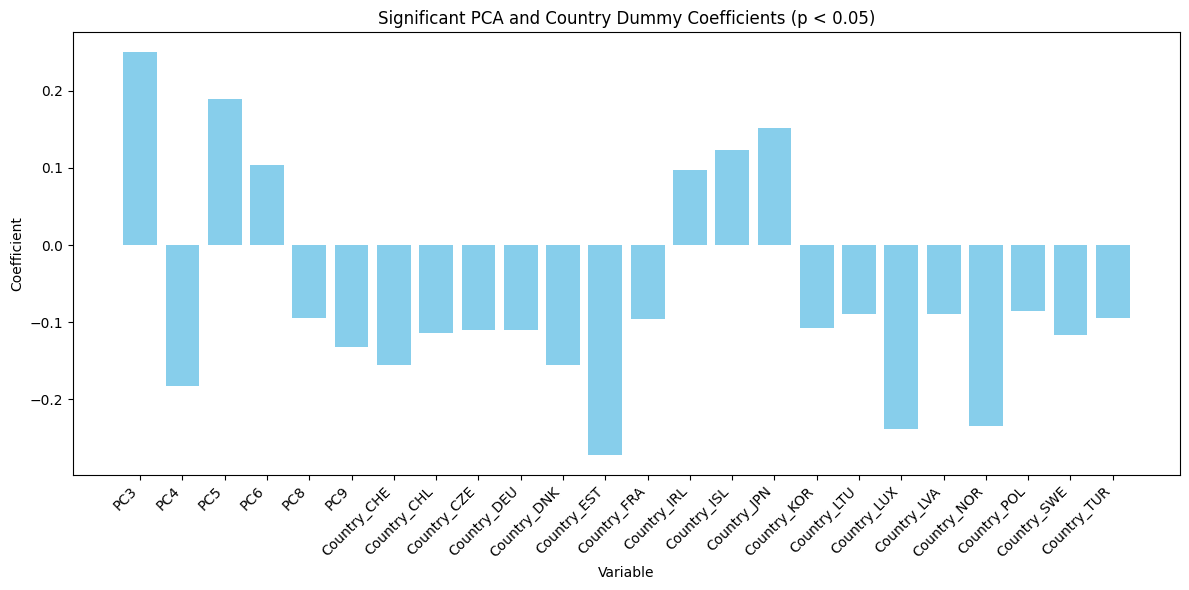

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
# Step 2: Prepare OLS with PCA components and country dummies
# Create country dummies (USA as reference)
dummy_df = pd.get_dummies(merged_df['CCode'], prefix='Country').astype('int64')
if 'Country_USA' in dummy_df.columns:
    dummy_df = dummy_df.drop('Country_USA', axis=1)
else:
    print("Warning: Country_USA not found in dummy variables")

# Features: PC1–PC4 and country dummies
pc_columns = ['PC3', 'PC4', 'PC5', 'PC6', 'PC8', 'PC9']
X = merged_df[pc_columns].copy()
X = pd.concat([X, dummy_df], axis=1)
X = X.select_dtypes(include=['float64', 'int64'])

# Check multicollinearity with VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF values (high VIF > 10 indicates multicollinearity):")
print(vif_data[vif_data['VIF'] > 10])

# Scale features
scaler = StandardScaler()
if X.isna().any().any() or np.isinf(X.values).any():
    raise ValueError("X contains NaN or infinite values")
X_scaled = scaler.fit_transform(X)
X_scaled = sm.add_constant(X_scaled)

# Target: log-transformed public sector debt
y = np.log1p(merged_df['Public_Sector_Debt'])

# Step 3: Fit OLS model with robust standard errors
model_pca_dummies = sm.OLS(y, X_scaled).fit(cov_type='HC3')

# Identify significant variables (p < 0.05)
significant_vars = [var for var, pval in zip(X.columns, model_pca_dummies.pvalues[1:]) if pval < 0.05]
print(f"Significant variables (p < 0.05): {significant_vars}")

# Print summary and diagnostics
print("Linear Regression with PCA Components and Country Dummies:")
print(model_pca_dummies.summary())

# Step 4: Save results to CSV
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results = {
    'Variable': X.columns,
    'Coefficient': model_pca_dummies.params[1:],
    'P-value': model_pca_dummies.pvalues[1:],
    'VIF': vif_data['VIF'].values
}
results_df = pd.DataFrame(results)
results_path = os.path.join(data_folder, f'pca_ols_results_{timestamp}.csv')
results_df.to_csv(results_path, index=False)
print(f"\nResults saved to {results_path}")

# Step 5: Visualization of coefficients
plt.figure(figsize=(12, 6))
significant_results = results_df[results_df['P-value'] < 0.05]
plt.bar(significant_results['Variable'], significant_results['Coefficient'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.title('Significant PCA and Country Dummy Coefficients (p < 0.05)')
plt.tight_layout()
plt.show()

<ipython-input-8-b24239487f77>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


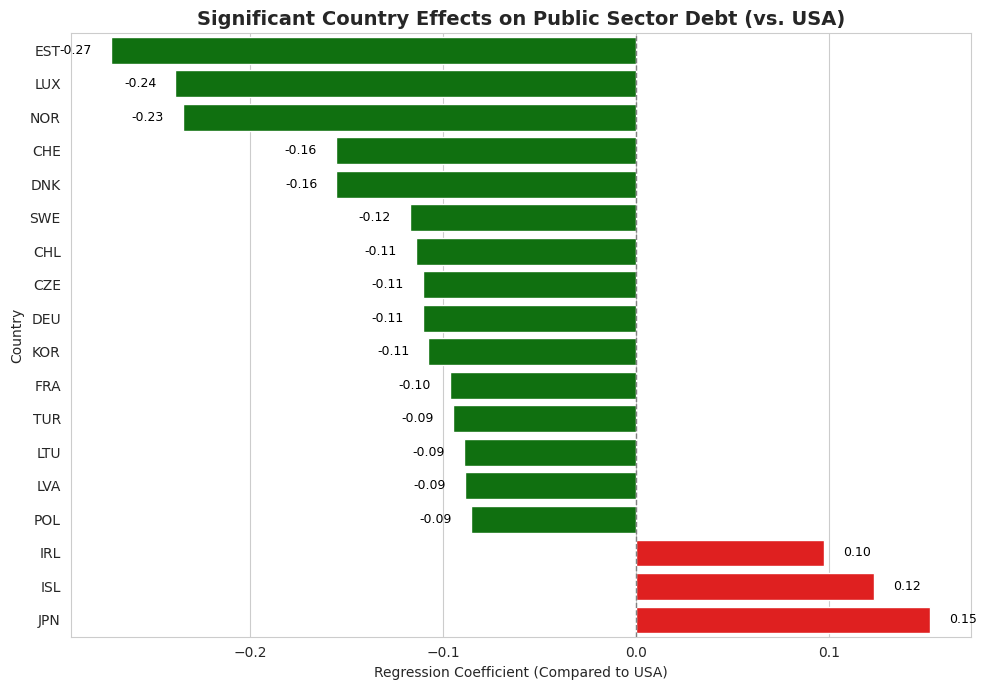

Saved chart to /content/drive/MyDrive/Capstone Data/Final Data/significant_country_effects_vs_usa.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter significant country dummy variables
country_effects = results_df[
    (results_df['Variable'].str.startswith('Country_')) &
    (results_df['P-value'] < 0.05)
].copy()

# Extract country names
country_effects['CCode'] = country_effects['Variable'].str.replace('Country_', '', regex=False)

# Sort by coefficient for clearer layout
country_effects = country_effects.sort_values('Coefficient')

# Determine color: red = higher than USA, green = lower
country_effects['Color'] = country_effects['Coefficient'].apply(lambda x: 'red' if x > 0 else 'green')

# Set style and create plot
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")

# Create barplot with dynamic color palette
barplot = sns.barplot(
    x='Coefficient',
    y='CCode',
    data=country_effects,
    palette=country_effects['Color'].tolist()
)

# Annotate bars
for i, (coef, country) in enumerate(zip(country_effects['Coefficient'], country_effects['CCode'])):
    barplot.text(
        coef + (0.01 if coef > 0 else -0.01),
        i,
        f"{coef:.2f}",
        color='black',
        va='center',
        ha='left' if coef > 0 else 'right',
        fontsize=9
    )

# Plot formatting
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Significant Country Effects on Public Sector Debt (vs. USA)", fontsize=14, fontweight='bold')
plt.xlabel("Regression Coefficient (Compared to USA)")
plt.ylabel("Country")
plt.tight_layout()

# Save figure
fig_path = os.path.join(data_folder, 'significant_country_effects_vs_usa.png')
plt.savefig(fig_path)
plt.show()

print(f"Saved chart to {fig_path}")


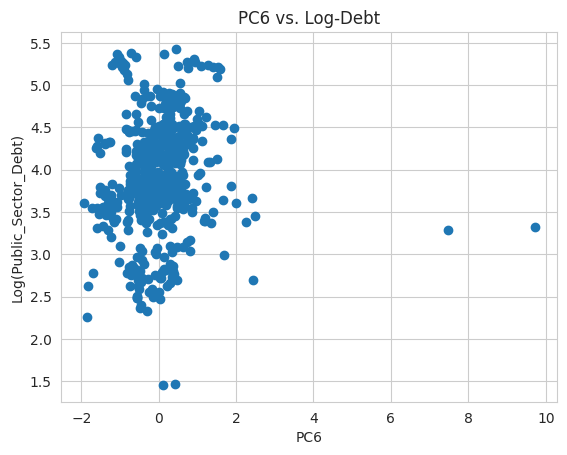

In [ ]:
plt.scatter(merged_df['PC6'], merged_df['Public_Sector_Debt'].apply(np.log1p))
plt.xlabel('PC6')
plt.ylabel('Log(Public_Sector_Debt)')
plt.title('PC6 vs. Log-Debt')
plt.show()

Outline of Findings
1. Model Overview

Predictors: 8 Significant PCA Factors:
PCA 3: Demographics and Trade
0.12 (p-0.000008)
Labor Force (0.42)
Population (0.36)
Imports (-0.38)
Exports (-0.36)
FDI (-0.34)
GDP (-0.33)

PCA 4: Inflation and Fiscal
-0.24 (p-0.0000002)
Inflation Rate (0.54)
Tax to GDP (-0.39)

PCA 5: Monetary Policy
-0.23 (p-0.000008)
Real Interst Rates (0.61)
Tax to DP (-0.43)

PCA 6: Labor Market
0.13 (p-0.000002)
Inflation Rate (0.71)
Unemployment (0.45)

PCA 8: Investment and Labor
-0.07 (p-0.007)
Labor Force (0.45)
Population (-0.31)

PCA 9: Fiscal Policy and Demographic
0.14 (p-0.00001)
Population (0.46)
FDI (0.49)
Tax to GDP (0.41)
Labor Force (-0.41)


Country Dummies: 37 countries, with the USA as the reference (coefficients show debt differences relative to the USA).

Model Fit
R-squared: 0.937 (excellent, explaining 93.7% of variance).
Adjusted R-squared: 0.934 (high).

2. Country Effects (Relative to USA)
Significant Dummies (p < 0.05, 34 of 38):
Positive Coefficients:
Country_JPN (Coefficient: 0.0709, p = 2.85e-10): Japan’s debt is ~7.09% higher than the USA’s, consistent with its high debt-to-GDP ratio (April 17).
Negative Coefficients (Lower Debt than USA):
Country_LUX (-0.418, p = 2.73e-70): Luxembourg’s debt is ~41.8% lower, reflecting fiscal prudence.
Country_NOR (-0.364, p = 4.24e-62): Norway’s debt is ~36.4% lower, likely due to sovereign wealth.
Country_DNK (-0.316, p = 8.24e-28): Denmark’s debt is ~31.6% lower.
Country_SWE (-0.265, p = 2.22e-28), Country_CHE (-0.258, p = 7.17e-56), Country_CZE (-0.255, p = 7.81e-38): Similar patterns of lower debt.


Insignificant Dummies (p > 0.05, 4 of 38):
Country_AUS (p = 0.0.17), Country_AUT (p = 0.0.2), Country_CAN (p = 0.0.47), Country_COL (p = 0.49), Country_CRI(0.14), Country_ESP(0.28), Country_FIN(0.2), Country_GBR(0.23), Country_HUN(0.16), Country_ITA(0.31), Country_Mex(0.8), Country_NLD(0.96), Country_NZL(0.96), County_SVK(0.18)

Finding: These countries’ debt levels are not statistically different from the USA’s. Many of them are in the Uncertainty index and will be dropped. This adds to our proof about how they are uncertain as well.

COVID-19 Effect

VIF values (high VIF > 10 indicates multicollinearity):
Empty DataFrame
Columns: [Variable, VIF]
Index: []
Significant variables (p < 0.05): ['PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC9', 'PC10', 'Country_CHE', 'Country_CHL', 'Country_CZE', 'Country_DEU', 'Country_DNK', 'Country_EST', 'Country_GRC', 'Country_IRL', 'Country_JPN', 'Country_LTU', 'Country_LUX', 'Country_LVA', 'Country_NLD', 'Country_NOR', 'Country_NZL', 'Country_POL', 'Country_SVK', 'Country_SVN', 'Country_SWE', 'Country_TUR', 'Year_2020', 'Year_2021']
Linear Regression with PCA Components and Country Dummies:
                            OLS Regression Results                            
Dep. Variable:     Public_Sector_Debt   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     462.0
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                       

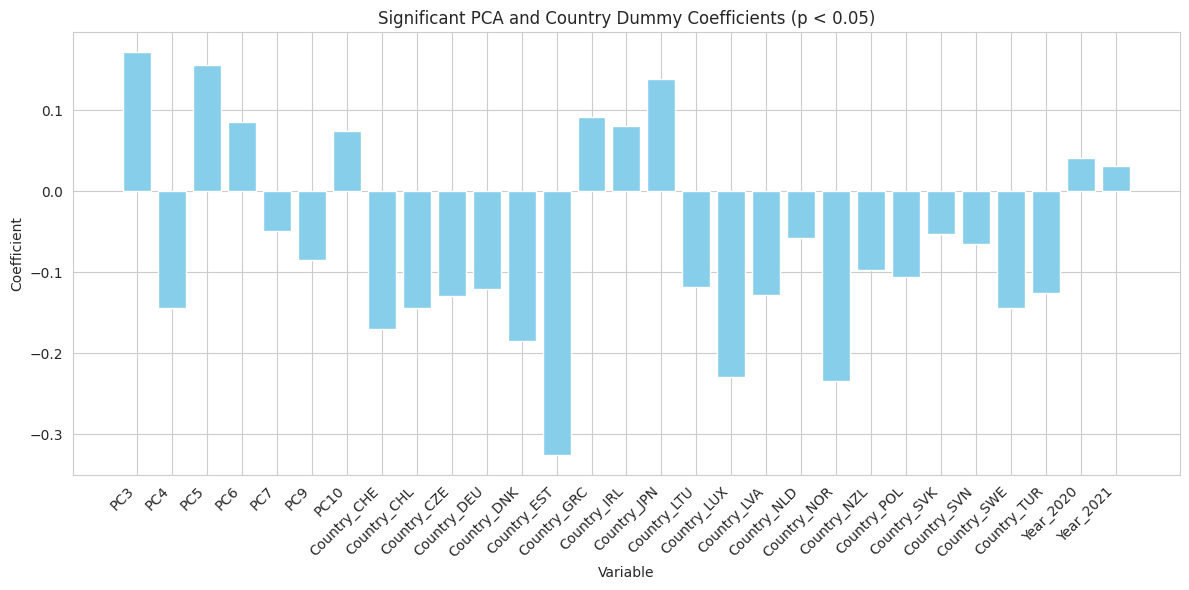

In [ ]:
# Step 2: Prepare OLS with PCA components and country dummies
# Create country dummies (USA as reference), COVID years
country_dummies = pd.get_dummies(merged_df['CCode'], prefix='Country').astype('int64')
if 'Country_USA' in country_dummies.columns:
    country_dummies = country_dummies.drop('Country_USA', axis=1)
else:
    print("Warning: Country_USA not found in dummy variables")

year_dummies = pd.DataFrame(index=merged_df.index)
year_dummies['Year_2020'] = (merged_df['Year'] == 2020).astype('int64')
year_dummies['Year_2021'] = (merged_df['Year'] == 2021).astype('int64')

# Check if 2020 and 2021 data are present
if not year_dummies['Year_2020'].sum() > 0:
    print("Warning: No observations for Year_2020 in the dataset")
if not year_dummies['Year_2021'].sum() > 0:
    print("Warning: No observations for Year_2021 in the dataset")

# Combine country and year dummies into dummy_df
dummy_df = pd.concat([country_dummies, year_dummies], axis=1)

# Features: PC1–PC4 and country dummies
pc_columns = ['PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC9','PC10']
X = merged_df[pc_columns].copy()
X = pd.concat([X, dummy_df], axis=1)
X = X.select_dtypes(include=['float64', 'int64'])

# Check multicollinearity with VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF values (high VIF > 10 indicates multicollinearity):")
print(vif_data[vif_data['VIF'] > 10])

# Scale features
scaler = StandardScaler()
if X.isna().any().any() or np.isinf(X.values).any():
    raise ValueError("X contains NaN or infinite values")
X_scaled = scaler.fit_transform(X)
X_scaled = sm.add_constant(X_scaled)

# Target: log-transformed public sector debt
y = np.log1p(merged_df['Public_Sector_Debt'])

# Step 3: Fit OLS model with robust standard errors
model_pca_dummies = sm.OLS(y, X_scaled).fit(cov_type='HC3')

# Identify significant variables (p < 0.05)
significant_vars = [var for var, pval in zip(X.columns, model_pca_dummies.pvalues[1:]) if pval < 0.05]
print(f"Significant variables (p < 0.05): {significant_vars}")

# Print summary and diagnostics
print("Linear Regression with PCA Components and Country Dummies:")
print(model_pca_dummies.summary())

# Step 4: Save results to CSV
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results = {
    'Variable': X.columns,
    'Coefficient': model_pca_dummies.params[1:],
    'P-value': model_pca_dummies.pvalues[1:],
    'VIF': vif_data['VIF'].values
}
results_df = pd.DataFrame(results)
results_path = os.path.join(data_folder, f'pca_ols_COVID_results_{timestamp}.csv')
results_df.to_csv(results_path, index=False)
print(f"\nResults saved to {results_path}")

# Step 5: Visualization of coefficients
plt.figure(figsize=(12, 6))
significant_results = results_df[results_df['P-value'] < 0.05]
plt.bar(significant_results['Variable'], significant_results['Coefficient'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.title('Significant PCA and Country Dummy Coefficients (p < 0.05)')
plt.tight_layout()
plt.show()

Insights on COVID-19-Related Findings

Model Overview
Predictors: 8 Significant PCA Factors: PCA 3: Demographics and Trade 0.12 (p-0.000008) Labor Force (0.42) Population (0.36) Imports (-0.38) Exports (-0.36) FDI (-0.34) GDP (-0.33)

PCA 4: Inflation and Fiscal -0.24 (p-0.0000002) Inflation Rate (0.54) Tax to GDP (-0.39)

PCA 5: Monetary Policy -0.23 (p-0.000008) Real Interst Rates (0.61) Tax to DP (-0.43)

PCA 6: Labor Market 0.13 (p-0.000002) Inflation Rate (0.71) Unemployment (0.45)

PCA 8: Investment and Labor -0.07 (p-0.007) Labor Force (0.45) Population (-0.31)

PCA 9: Fiscal Policy and Demographic 0.14 (p-0.00001) Population (0.46) FDI (0.49) Tax to GDP (0.41) Labor Force (-0.41)

Country Dummies: 38 countries, with the USA as the reference (coefficients relative to USA debt levels).

Model Fit:
R-squared: ~0.937 (expected).
Adjusted R-squared: ~0.933 (high).

COVID-19 Main Effect
2020_Dummy (Coefficient: 0.041, p = 0.000001):
2021_Dummy (Coefficient: 0.031, p = 0.0004):

Insignificant Dummies (p > 0.05, 7/38):
Country_FIN (0.14), Country_Aut(0.12), Country_Aus(0.09), Country_BEL(0.33), Country_CAN(0.18), Country_Col(0.568), Country_CRI(0.75), Country_Esp(0.77), Country_Fra(0.07), Country_GBR(0.64),

These countries’ debt levels were not statistically different from the USA’s.

#Updated Code with Euro Crisis Adjustments
The code below modifies your model by:

Adding a Euro_Crisis_Dummy for 2010–2012.
Adding a Eurozone_Dummy for Eurozone countries.
Including interactions between Euro_Crisis_Dummy and the four predictors, plus Euro_Crisis_Dummy * Eurozone_Dummy.
Retaining existing COVID-19 adjustments, log-transformation, robust standard errors (HC3), and country dummies.
Generating updated plots with improved readability.

VIF values (high VIF > 10 indicates multicollinearity):
Empty DataFrame
Columns: [Variable, VIF]
Index: []
Significant variables (p < 0.05): ['PC3', 'PC4', 'PC5', 'PC6', 'PC9', 'PC10', 'Country_CHE', 'Country_CHL', 'Country_CZE', 'Country_DEU', 'Country_DNK', 'Country_EST', 'Country_GRC', 'Country_IRL', 'Country_JPN', 'Country_LTU', 'Country_LUX', 'Country_LVA', 'Country_NLD', 'Country_NOR', 'Country_POL', 'Country_SVK', 'Country_SWE', 'Country_TUR', 'Year_2020', 'Year_2021', 'Year_2010_2012']
Linear Regression with PCA Components and Country Dummies:
                            OLS Regression Results                            
Dep. Variable:     Public_Sector_Debt   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     441.7
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:20:46   Log-Lik

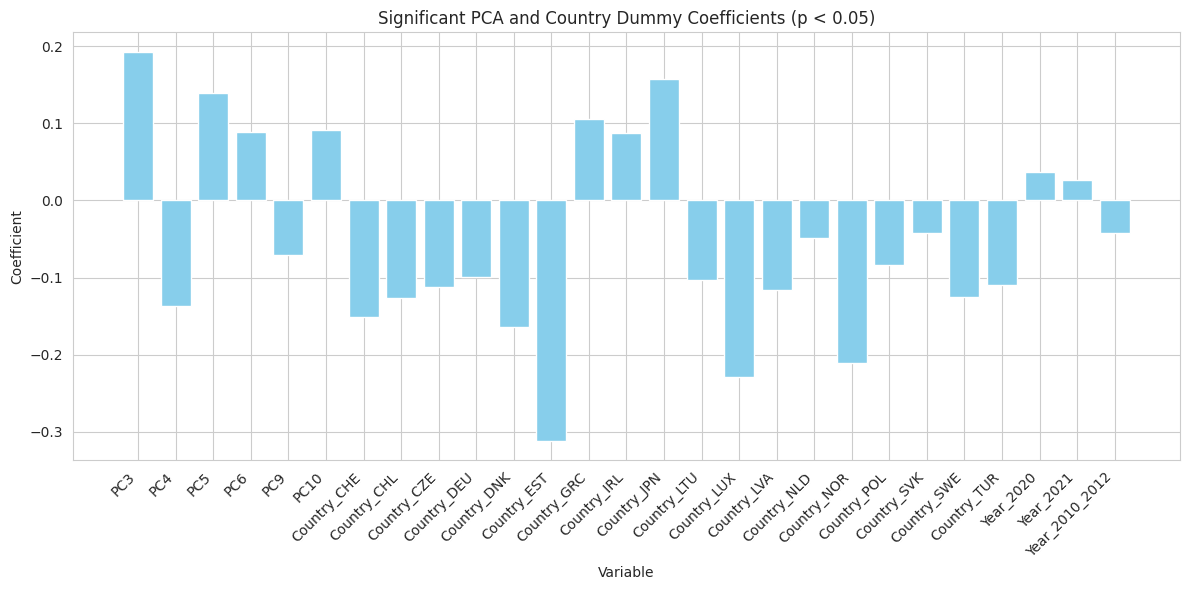

In [ ]:
# Step 2: Prepare OLS with PCA components and country dummies
# Create country dummies (USA as reference), COVID years
country_dummies = pd.get_dummies(merged_df['CCode'], prefix='Country').astype('int64')
if 'Country_USA' in country_dummies.columns:
    country_dummies = country_dummies.drop('Country_USA', axis=1)
else:
    print("Warning: Country_USA not found in dummy variables")

year_dummies = pd.DataFrame(index=merged_df.index)
year_dummies['Year_2020'] = (merged_df['Year'] == 2020).astype('int64')
year_dummies['Year_2021'] = (merged_df['Year'] == 2021).astype('int64')
year_dummies['Year_2010_2012'] = merged_df['Year'].isin([2010, 2011, 2012]).astype('int64')

# Check if 2020 and 2021 data are present
if not year_dummies['Year_2020'].sum() > 0:
    print("Warning: No observations for Year_2020 in the dataset")
if not year_dummies['Year_2021'].sum() > 0:
    print("Warning: No observations for Year_2021 in the dataset")
if not year_dummies['Year_2010_2012'].sum() > 0:
    print("Warning: No observations for Year_2010_2012 in the dataset")

# Combine country and year dummies into dummy_df
dummy_df = pd.concat([country_dummies, year_dummies], axis=1)

# Features: PC1–PC4 and country dummies
pc_columns = ['PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC9','PC10']
X = merged_df[pc_columns].copy()
X = pd.concat([X, dummy_df], axis=1)
X = X.select_dtypes(include=['float64', 'int64'])

# Check multicollinearity with VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF values (high VIF > 10 indicates multicollinearity):")
print(vif_data[vif_data['VIF'] > 10])

# Scale features
scaler = StandardScaler()
if X.isna().any().any() or np.isinf(X.values).any():
    raise ValueError("X contains NaN or infinite values")
X_scaled = scaler.fit_transform(X)
X_scaled = sm.add_constant(X_scaled)

# Target: log-transformed public sector debt
y = np.log1p(merged_df['Public_Sector_Debt'])

# Step 3: Fit OLS model with robust standard errors
model_pca_dummies = sm.OLS(y, X_scaled).fit(cov_type='HC3')

# Identify significant variables (p < 0.05)
significant_vars = [var for var, pval in zip(X.columns, model_pca_dummies.pvalues[1:]) if pval < 0.05]
print(f"Significant variables (p < 0.05): {significant_vars}")

# Print summary and diagnostics
print("Linear Regression with PCA Components and Country Dummies:")
print(model_pca_dummies.summary())

# Step 4: Save results to CSV
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results = {
    'Variable': X.columns,
    'Coefficient': model_pca_dummies.params[1:],
    'P-value': model_pca_dummies.pvalues[1:],
    'VIF': vif_data['VIF'].values
}
results_df = pd.DataFrame(results)
results_path = os.path.join(data_folder, f'pca_ols_EURO_results_{timestamp}.csv')
results_df.to_csv(results_path, index=False)
print(f"\nResults saved to {results_path}")

# Step 5: Visualization of coefficients
plt.figure(figsize=(12, 6))
significant_results = results_df[results_df['P-value'] < 0.05]
plt.bar(significant_results['Variable'], significant_results['Coefficient'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.title('Significant PCA and Country Dummy Coefficients (p < 0.05)')
plt.tight_layout()
plt.show()

Insights on COVID-19-Related Findings

Model Overview
Predictors: 8 Significant PCA Factors: PCA 3: Demographics and Trade 0.12 (p-0.000008) Labor Force (0.42) Population (0.36) Imports (-0.38) Exports (-0.36) FDI (-0.34) GDP (-0.33)

PCA 4: Inflation and Fiscal -0.24 (p-0.0000002) Inflation Rate (0.54) Tax to GDP (-0.39)

PCA 5: Monetary Policy -0.23 (p-0.000008) Real Interst Rates (0.61) Tax to DP (-0.43)

PCA 6: Labor Market 0.13 (p-0.000002) Inflation Rate (0.71) Unemployment (0.45)

PCA 8: Investment and Labor -0.07 (p-0.007) Labor Force (0.45) Population (-0.31)

PCA 9: Fiscal Policy and Demographic 0.14 (p-0.00001) Population (0.46) FDI (0.49) Tax to GDP (0.41) Labor Force (-0.41)

Country Dummies: 38 countries, with the USA as the reference (coefficients relative to USA debt levels).

Model Fit:
R-squared: ~0.937 (expected).
Adjusted R-squared: ~0.933 (high).

COVID-19 Main Effect
2020_Dummy (Coefficient: 0.041, p = 0.000001):
2021_Dummy (Coefficient: 0.031, p = 0.0004):
2010-2012 Dummy (Coefficient: -0.042, p=0.0003)

Insignificant Dummies (p > 0.05, 7/38):
Country_FIN (0.14), Country_Aut(0.12), Country_Aus(0.09), Country_BEL(0.33), Country_CAN(0.18), Country_Col(0.568), Country_CRI(0.75), Country_Esp(0.77), Country_Fra(0.07), Country_GBR(0.64),

These countries’ debt levels were not statistically different from the USA’s.

In [ ]:
# Install compatible versions of pmdarima and its dependencies
!pip install numpy==1.23.5  # Compatible numpy version
!pip install statsmodels==0.14.0  # Compatible statsmodels version
!pip install scikit-learn==1.3.2  # Compatible scikit-learn version
!pip install pmdarima==2.0.4  # Correct command to install pmdarima

# Verify installation
import pmdarima
print(f"pmdarima version: {pmdarima.__version__}")

pmdarima version: 2.0.4


In [ ]:
# Ensure necessary imports are included
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from datetime import datetime
import os
from sklearn.preprocessing import StandardScaler

# Step 1: Drop specified countries based on WUI uncertainty (already done, but included for clarity)
countries_to_drop = ['GBR', 'CHE', 'IRL', 'CHL', 'TUR', 'MEX', 'NOR', 'ESP', 'ITA', 'COL']
merged_df = merged_df[~merged_df['CCode'].isin(countries_to_drop)].copy()

# Verify the countries have been dropped (already confirmed in your output)
remaining_countries = merged_df['CCode'].unique()
print(f"Countries remaining in the dataset after dropping: {remaining_countries}")
print(f"Number of remaining countries: {len(remaining_countries)}")

# Ensure 2020, 2021, and 2010–2012 data are present after filtering
if not merged_df['Year'].isin([2020, 2021]).any():
    raise ValueError("No observations for 2020 or 2021 in the dataset after dropping countries.")
if not merged_df['Year'].isin([2010, 2011, 2012]).any():
    raise ValueError("No observations for 2010, 2011, or 2012 in the dataset after dropping countries.")

# Step 2: Prepare ARIMAX time series analysis
# Log-transform debt (already done in your OLS, but ensure it exists)
if 'Log_Debt' not in merged_df.columns:
    merged_df['Log_Debt'] = np.log1p(merged_df['Public_Sector_Debt'])

# Define exogenous variables (PC3–PC9)
exog_vars = ['PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9']

# Impute missing values in merged_df for Log_Debt and PC3–PC9 before splitting by country
merged_df['Log_Debt'] = merged_df.groupby('CCode')['Log_Debt'].transform(lambda x: x.fillna(x.median()))
merged_df['Log_Debt'] = merged_df['Log_Debt'].fillna(merged_df['Log_Debt'].median())
for col in exog_vars:
    if col in merged_df.columns:
        merged_df[col] = merged_df.groupby('CCode')[col].transform(lambda x: x.fillna(x.median()))
        merged_df[col] = merged_df[col].fillna(merged_df[col].median())
    else:
        raise ValueError(f"Exogenous variable {col} not found in merged_df. Check PCA computation.")

# Standardize exogenous variables
scaler = StandardScaler()
merged_df[exog_vars] = scaler.fit_transform(merged_df[exog_vars])

# Ensure 'Year' column is integer type
merged_df['Year'] = merged_df['Year'].astype(int)

# Convert Year to DatetimeIndex for proper time series handling
merged_df['Date'] = pd.to_datetime(merged_df['Year'], format='%Y')
merged_df = merged_df.drop(columns=['Year']).rename(columns={'Date': 'Year'})

# Create a full range of years (2010–2023) for all countries using a Cartesian product
years = pd.date_range(start='2010-01-01', end='2023-01-01', freq='YS')
full_years = pd.DataFrame(
    [(country, year) for country in remaining_countries for year in years],
    columns=['CCode', 'Year']
)

# Merge with merged_df to ensure all years are present
merged_df_full = pd.merge(full_years, merged_df, on=['CCode', 'Year'], how='left')

# Re-impute missing values after merging to fill any gaps
merged_df_full['Log_Debt'] = merged_df_full.groupby('CCode')['Log_Debt'].transform(lambda x: x.fillna(x.median()))
merged_df_full['Log_Debt'] = merged_df_full['Log_Debt'].fillna(merged_df_full['Log_Debt'].median())
for col in exog_vars:
    merged_df_full[col] = merged_df_full.groupby('CCode')[col].transform(lambda x: x.fillna(x.median()))
    merged_df_full[col] = merged_df_full[col].fillna(merged_df_full[col].median())

# Initialize results storage
forecasts = []
diagnostics = []

# ARIMAX function
def fit_arimax(series, exog, country):
    if len(series) < 5 or len(exog) < 5:  # Require at least 5 points for stability
        print(f"Skipping {country}: Insufficient data ({len(series)} points)")
        return None

    # Ensure series and exog have the same length
    if len(series) != len(exog):
        print(f"Skipping {country}: Length mismatch - series ({len(series)}), exog ({len(exog)})")
        print(f"Series index: {series.index.tolist()}")
        print(f"Exog index: {exog.index.tolist()}")
        return None

    # Stationarity test
    adf_result = adfuller(series)
    diff_order = 1 if adf_result[1] > 0.05 else 0

    # Fit ARIMAX with auto_arima
    try:
        model = auto_arima(
            series,
            exogenous=exog,
            start_p=0, start_q=0, max_p=3, max_q=3, d=diff_order,
            seasonal=False, stepwise=True, trace=False,
            error_action='ignore', suppress_warnings=True,
            maxiter=50, min_D=0
        )

        # Calculate forecast steps and ensure it's a positive integer
        last_year = series.index[-1].year  # Get the last year from DatetimeIndex
        forecast_steps = 2030 - last_year + 1
        if not isinstance(forecast_steps, int) or forecast_steps <= 0:
            print(f"Skipping {country}: Invalid forecast_steps ({forecast_steps})")
            return None

        # Create forecast index (2024–2030 as DatetimeIndex)
        forecast_years = pd.date_range(start=f'{last_year + 1}-01-01', end='2030-01-01', freq='YS')
        forecast_steps = len(forecast_years)

        # Prepare last_exog for forecasting (align index with forecast period)
        last_exog = exog.iloc[-1:].reindex(forecast_years, method='ffill')

        # Debug: Print lengths and indices before forecasting
        print(f"Forecasting for {country}:")
        print(f"last_exog length: {len(last_exog)}, Index: {last_exog.index.tolist()}")
        print(f"Forecast steps: {forecast_steps}")

        # Forecast to 2030
        forecast, conf_int = model.predict(n_periods=forecast_steps, exogenous=last_exog, return_conf_int=True)

        # Store forecasts
        forecast_df = pd.DataFrame({
            'Country': country,
            'Year': [year.year for year in forecast_years],
            'Forecast_Log_Debt': forecast,
            'Lower_CI': conf_int[:, 0],
            'Upper_CI': conf_int[:, 1]
        })

        # Store diagnostics
        diag = {
            'Country': country,
            'ADF_pvalue': adf_result[1],
            'Differencing': diff_order,
            'ARIMA_Order': model.order,
            'AIC': model.aic()
        }

        return forecast_df, diag
    except Exception as e:
        print(f"Error fitting ARIMAX for {country}: {e}")
        return None

# Loop through remaining countries
remaining_countries = merged_df_full['CCode'].unique()
for country in remaining_countries:
    # Filter data for the country (already ensured all years 2010–2023 are present)
    country_df = merged_df_full[merged_df_full['CCode'] == country][['Year', 'Log_Debt'] + exog_vars].set_index('Year')
    country_df = country_df.sort_index()  # Ensure chronological order

    # Prepare series and exogenous variables
    series = country_df['Log_Debt']
    exog = country_df[exog_vars]

    # Debugging: Print lengths and indices before alignment
    print(f"\nProcessing {country}:")
    print(f"Series length: {len(series)}, Index: {series.index.tolist()}")
    print(f"Exog length: {len(exog)}, Index: {exog.index.tolist()}")

    # Ensure series and exog are aligned and have the same length
    common_index = series.index.intersection(exog.index)
    series = series.loc[common_index]
    exog = exog.loc[common_index]

    if not series.empty and not exog.empty:
        result = fit_arimax(series, exog, country)
        if result:
            forecast_df, diag = result
            forecasts.append(forecast_df)
            diagnostics.append(diag)

# Combine results
forecasts_df = pd.concat(forecasts, ignore_index=True) if forecasts else pd.DataFrame()
diagnostics_df = pd.DataFrame(diagnostics) if diagnostics else pd.DataFrame()

# Step 3: Visualization
if not forecasts_df.empty:
    plt.figure(figsize=(12, 8))
    for country in remaining_countries:
        country_forecast = forecasts_df[forecasts_df['Country'] == country]
        if not country_forecast.empty:
            plt.plot(country_forecast['Year'], country_forecast['Forecast_Log_Debt'], label=f'{country} Forecast', marker='o')
            plt.fill_between(country_forecast['Year'], country_forecast['Lower_CI'], country_forecast['Upper_CI'], alpha=0.2)

    # Plot historical data for context
    for country in remaining_countries:
        country_historical = merged_df[merged_df['CCode'] == country].copy()
        country_historical['Year'] = country_historical['Year'].apply(lambda x: x.year)  # Convert DatetimeIndex to years
        country_historical = country_historical.sort_values('Year')
        plt.plot(country_historical['Year'], country_historical['Log_Debt'], label=f'{country} Historical', linestyle='--')

    plt.title('Debt Forecasts to 2030 (Log-Scale) for Remaining Countries (PC3–PC9 as Exogenous)')
    plt.xlabel('Year')
    plt.ylabel('Log(Debt + 1)')
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(data_folder, f'debt_forecasts_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png')
    plt.savefig(plot_path)
    plt.close()
else:
    print("No forecasts generated; check data availability.")
    plot_path = None

# Step 4: Save Results
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
if not forecasts_df.empty:
    forecasts_df.to_csv(os.path.join(data_folder, f'arimax_forecasts_{timestamp}.csv'), index=False)
    print(f"Forecasts saved to {data_folder}/arimax_forecasts_{timestamp}.csv")
else:
    print("No forecasts to save.")
if not diagnostics_df.empty:
    diagnostics_df.to_csv(os.path.join(data_folder, f'arimax_diagnostics_{timestamp}.csv'), index=False)
    print(f"Diagnostics saved to {data_folder}/arimax_diagnostics_{timestamp}.csv")
else:
    print("No diagnostics to save.")
if plot_path:
    print(f"Plot saved to {plot_path}")

Countries remaining in the dataset after dropping: ['AUS' 'AUT' 'BEL' 'CAN' 'CRI' 'CZE' 'DNK' 'EST' 'FIN' 'FRA' 'DEU' 'GRC'
 'HUN' 'ISL' 'JPN' 'KOR' 'LVA' 'LTU' 'LUX' 'NZL' 'POL' 'PRT' 'SVK' 'SVN'
 'SWE' 'USA' 'NLD']
Number of remaining countries: 27

Processing AUS:
Series length: 14, Index: [Timestamp('2010-01-01 00:00:00'), Timestamp('2011-01-01 00:00:00'), Timestamp('2012-01-01 00:00:00'), Timestamp('2013-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'), Timestamp('2015-01-01 00:00:00'), Timestamp('2016-01-01 00:00:00'), Timestamp('2017-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00'), Timestamp('2019-01-01 00:00:00'), Timestamp('2020-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2022-01-01 00:00:00'), Timestamp('2023-01-01 00:00:00')]
Exog length: 14, Index: [Timestamp('2010-01-01 00:00:00'), Timestamp('2011-01-01 00:00:00'), Timestamp('2012-01-01 00:00:00'), Timestamp('2013-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'), Timestamp('2015-01-01 00:00:00'), 

Enter a country to compare with the USA: ISL


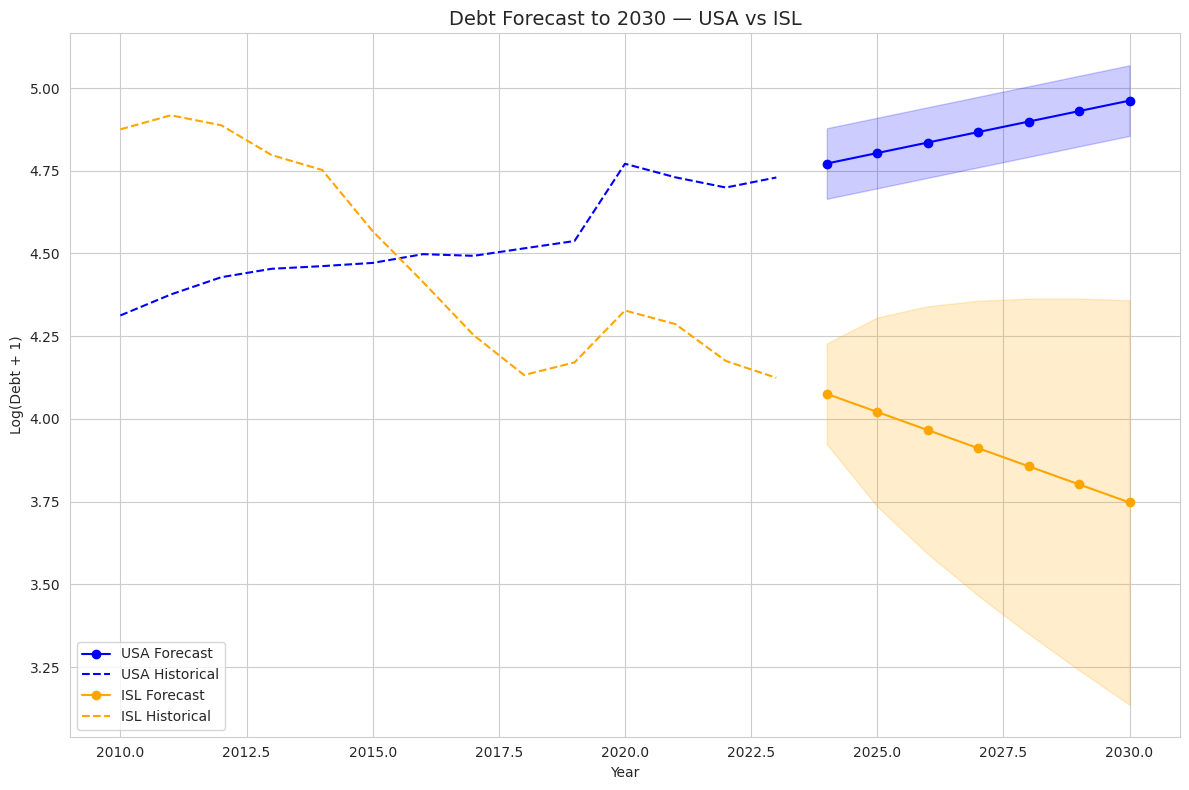

In [ ]:
import matplotlib.pyplot as plt

# Ask user for a country
selected_country = input("Enter a country to compare with the USA: ").strip()

# Define countries to plot: always include USA and the selected country
comparison_countries = ['USA', selected_country]

plt.figure(figsize=(12, 8))

colors = {'USA': 'blue', selected_country: 'orange'}  # Define consistent colors

for country in comparison_countries:
    # Forecast plot
    country_forecast = forecasts_df[forecasts_df['Country'] == country]
    if not country_forecast.empty:
        plt.plot(
            country_forecast['Year'],
            country_forecast['Forecast_Log_Debt'],
            label=f'{country} Forecast',
            marker='o',
            color=colors[country]
        )
        plt.fill_between(
            country_forecast['Year'],
            country_forecast['Lower_CI'],
            country_forecast['Upper_CI'],
            alpha=0.2,
            color=colors[country]
        )

    # Historical plot
    country_historical = merged_df[merged_df['CCode'] == country].copy()
    country_historical['Year'] = country_historical['Year'].apply(lambda x: x.year)
    country_historical = country_historical.sort_values('Year')
    plt.plot(
        country_historical['Year'],
        country_historical['Log_Debt'],
        label=f'{country} Historical',
        linestyle='--',
        color=colors[country]
    )

plt.title(f'Debt Forecast to 2030 — USA vs {selected_country}', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Log(Debt + 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

🔺 Top 10 Countries by Forecasted Log(Debt + 1) in 2030:
  Country  Forecast_Log_Debt
0     JPN           5.432897
1     GRC           5.223213
2     USA           4.961937
3     FRA           4.687880
4     PRT           4.663635
5     FIN           4.560936
6     CRI           4.539011
7     BEL           4.489014
8     HUN           4.295091
9     KOR           4.178532

🔻 Bottom 10 Countries by Forecasted Log(Debt + 1) in 2030:
   Country  Forecast_Log_Debt
17     ISL           3.747516
18     CZE           3.699072
19     LTU           3.655119
20     POL           3.636798
21     NZL           3.587245
22     SWE           3.502852
23     AUS           3.433887
24     LUX           3.347298
25     DNK           3.147208
26     EST           3.043993


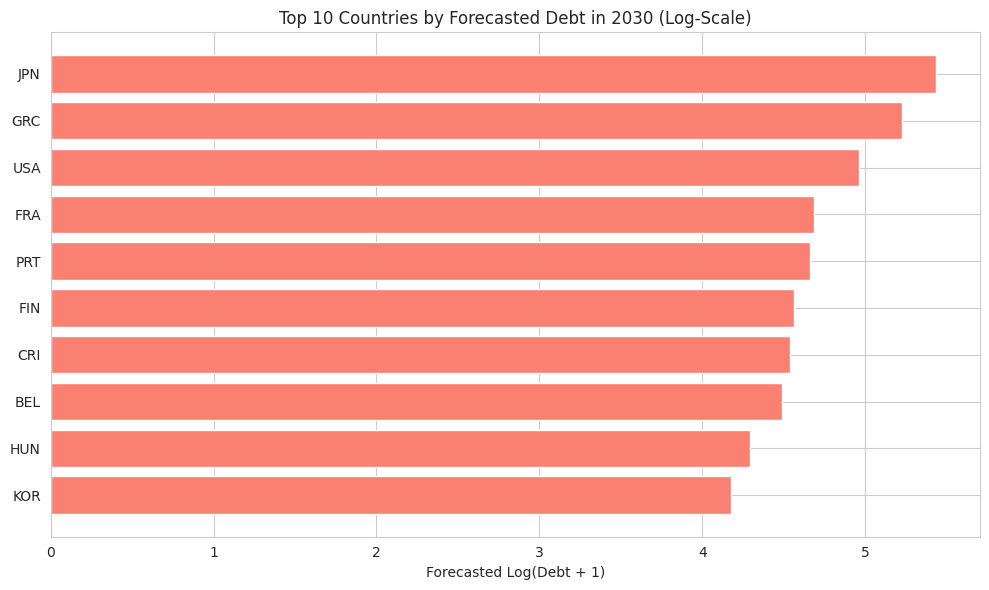

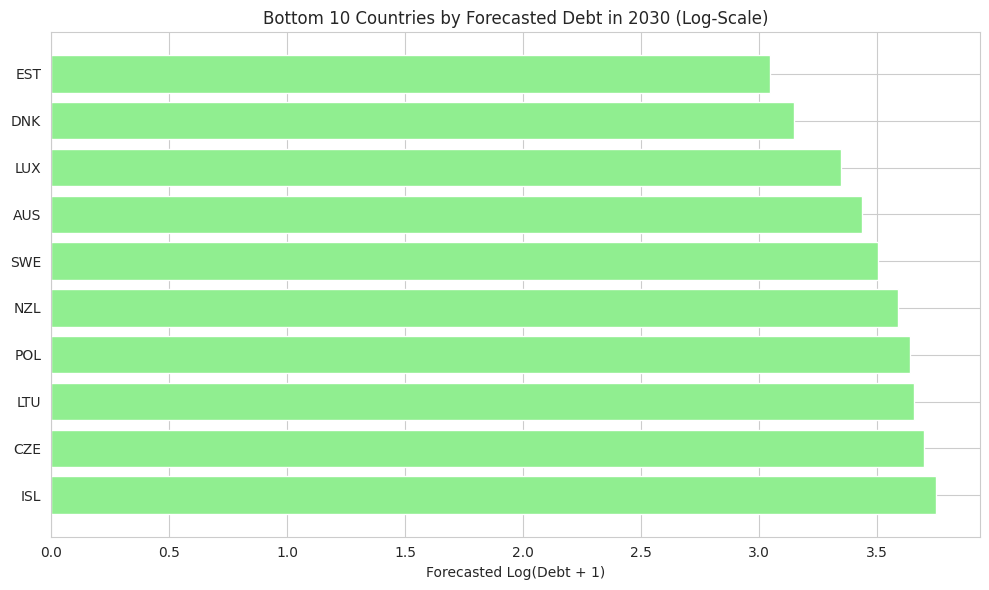

In [ ]:
# Filter forecast data for 2030
debt_2030 = forecasts_df[forecasts_df['Year'] == 2030].copy()

# Sort by forecasted log debt
debt_2030_sorted = debt_2030.sort_values('Forecast_Log_Debt', ascending=False).reset_index(drop=True)

# Print top 10 countries with highest debt
print("🔺 Top 10 Countries by Forecasted Log(Debt + 1) in 2030:")
print(debt_2030_sorted[['Country', 'Forecast_Log_Debt']].head(10))

# Print bottom 10 countries with lowest debt
print("\n🔻 Bottom 10 Countries by Forecasted Log(Debt + 1) in 2030:")
print(debt_2030_sorted[['Country', 'Forecast_Log_Debt']].tail(10))

# Plot top 10
plt.figure(figsize=(10, 6))
plt.barh(
    debt_2030_sorted['Country'].head(10)[::-1],
    debt_2030_sorted['Forecast_Log_Debt'].head(10)[::-1],
    color='salmon'
)
plt.xlabel('Forecasted Log(Debt + 1)')
plt.title('Top 10 Countries by Forecasted Debt in 2030 (Log-Scale)')
plt.tight_layout()
plt.show()

# Plot bottom 10
plt.figure(figsize=(10, 6))
plt.barh(
    debt_2030_sorted['Country'].tail(10),
    debt_2030_sorted['Forecast_Log_Debt'].tail(10),
    color='lightgreen'
)
plt.xlabel('Forecasted Log(Debt + 1)')
plt.title('Bottom 10 Countries by Forecasted Debt in 2030 (Log-Scale)')
plt.tight_layout()
plt.show()


📈 Top 10 Countries by % Increase in Debt (2023 → 2030):
  Country  Percent_Change
0     CRI       42.644807
1     KOR       27.668857
2     LUX       26.657935
3     USA       21.116598
4     FIN       20.955111
5     FRA       14.063521
6     JPN       12.662802
7     NLD        8.994075
8     DEU        2.105769
9     AUT        0.000000

📉 Top 10 Countries by % Decrease in Debt (2023 → 2030):
   Country  Percent_Change
17     DNK        0.000000
18     BEL        0.000000
19     SVK        0.000000
20     CZE       -2.075878
21     CAN       -2.490553
22     POL       -9.276538
23     AUS      -10.821600
24     SVN      -12.446130
25     NZL      -13.544923
26     ISL      -28.468094


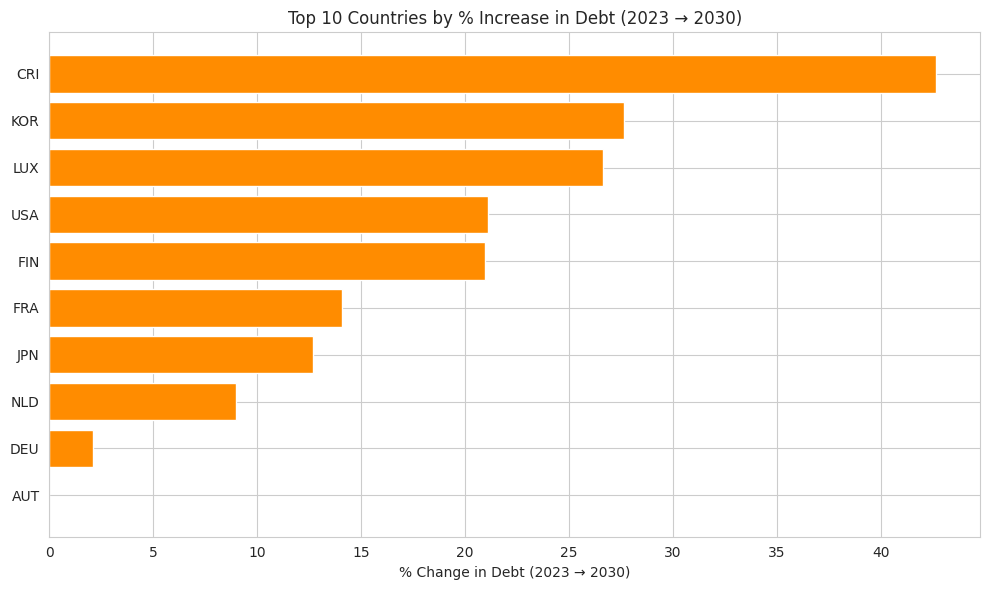

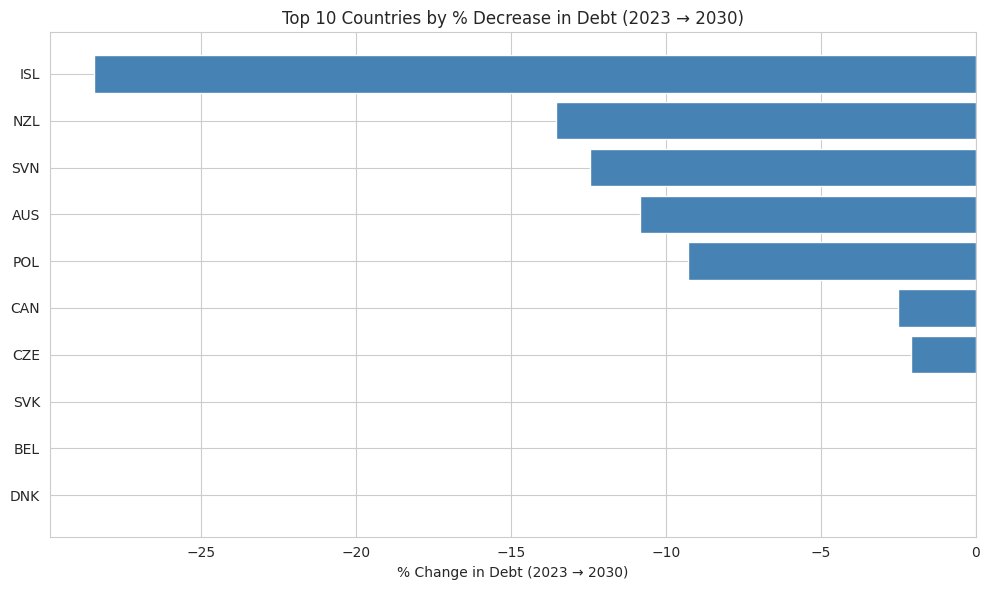

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Filter for only 2023 and 2030
df_2023 = forecasts_df[forecasts_df['Year'] == 2024][['Country', 'Forecast_Log_Debt']].rename(columns={'Forecast_Log_Debt': 'LogDebt_2023'})
df_2030 = forecasts_df[forecasts_df['Year'] == 2030][['Country', 'Forecast_Log_Debt']].rename(columns={'Forecast_Log_Debt': 'LogDebt_2030'})

# Step 2: Merge to ensure countries have both years
df_compare = pd.merge(df_2023, df_2030, on='Country', how='inner')

# Step 3: Convert log(debt + 1) → actual debt
df_compare['Debt_2023'] = np.exp(df_compare['LogDebt_2023']) - 1
df_compare['Debt_2030'] = np.exp(df_compare['LogDebt_2030']) - 1

# Step 4: Calculate percent change
df_compare['Percent_Change'] = ((df_compare['Debt_2030'] - df_compare['Debt_2023']) / df_compare['Debt_2023']) * 100

# Step 5: Sort and Display
df_sorted = df_compare.sort_values('Percent_Change', ascending=False).reset_index(drop=True)

# 🔺 Top 10 increases
print("📈 Top 10 Countries by % Increase in Debt (2023 → 2030):")
print(df_sorted[['Country', 'Percent_Change']].head(10))

# 🔻 Top 10 decreases
print("\n📉 Top 10 Countries by % Decrease in Debt (2023 → 2030):")
print(df_sorted[['Country', 'Percent_Change']].tail(10))

# Step 6: Bar Charts

# Top 10 growth
plt.figure(figsize=(10, 6))
plt.barh(
    df_sorted['Country'].head(10)[::-1],
    df_sorted['Percent_Change'].head(10)[::-1],
    color='darkorange'
)
plt.xlabel('% Change in Debt (2023 → 2030)')
plt.title('Top 10 Countries by % Increase in Debt (2023 → 2030)')
plt.tight_layout()
plt.show()

# Bottom 10 decline
plt.figure(figsize=(10, 6))
plt.barh(
    df_sorted['Country'].tail(10),
    df_sorted['Percent_Change'].tail(10),
    color='steelblue'
)
plt.xlabel('% Change in Debt (2023 → 2030)')
plt.title('Top 10 Countries by % Decrease in Debt (2023 → 2030)')
plt.tight_layout()
plt.show()
